# NAO example notebook

This notebook contains an example of access of ERA5 data with the `Reader` class and evaluation of the NAO teleconnection (station based index) with `aqua` libraries and an example of the plotting routines.

In [1]:
import datetime
import sys
from aqua import Reader
sys.path.insert(0, '../') # Hack to import from parent directory, to be removed
from index import station_based_index
from plots import index_plot, reg_plot
from tools import load_namelist

FDB5 binary library not present on system, disabling FDB support.


## Teleconnection details configuration

Details such as teleconnection coordinates, folder input/output are obtained with functions collected in the `tools.py` file, that access details from a `yaml` file.
The function `load_namelist` loads data specific to the choosen teleconnection such as coordinates.

Details about the NAO teleconnection can be accessed by specificing the teleconnection name as a string.
The field required to evaluate the teleconnection is also specified in the `namelist`.

In [2]:
diagname  = 'teleconnections'
telecname = 'NAO'
model = 'ERA5'
exp = 'era5'
source = 'monthly'

namelist = load_namelist(diagname)

field = namelist[telecname]['field']

## Retrieve data with the intake AQUA functionality

Data required for the NAO teleconnection are retrieved with the `Reader` class from the `AQUA` framework (see framework notebooks for a comprehensive list of examples).

In [3]:
reader = Reader(model=model,exp=exp,source=source,regrid='r100')
data = reader.retrieve(var=field)

infile = data[field]
infile = reader.regrid(infile)
infile = infile

## Index evaluation

The NAO index can be evaluated by using the library function `station_based_index` from the `index.py` file.

The index can be evaluated with a custom rolling window to average data (standard is 3 months, here written explicitely for sake of clarity).

The function returns a `DataArray` with the timeserie of index values.

2023-06-13 14:51:04 :: station based index :: INFO     -> Evaluating station based index for NAO
/work/bb1153/b382289/mambaforge/envs/teleconnections/lib/python3.10/site-packages/xarray/core/indexing.py:1443: PerformanceWarning: Slicing with an out-of-order index is generating 83 times more chunks
  return self.array[key]
2023-06-13 14:51:04 :: station based index :: INFO     -> Data longitudes are 0-360, converting teleconnection coords
2023-06-13 14:51:04 :: station based index :: INFO     -> Station 1: lon = 334.3, lat = 37.7
2023-06-13 14:51:04 :: station based index :: INFO     -> Station 2: lon = 338, lat = 64.1
2023-06-13 14:51:29 :: station based index :: INFO     -> Index evaluated


(<Figure size 1200x800 with 1 Axes>,
 <Axes: title={'center': 'NAO index'}, xlabel='time', ylabel='Mean sea level pressure [Pa]'>)

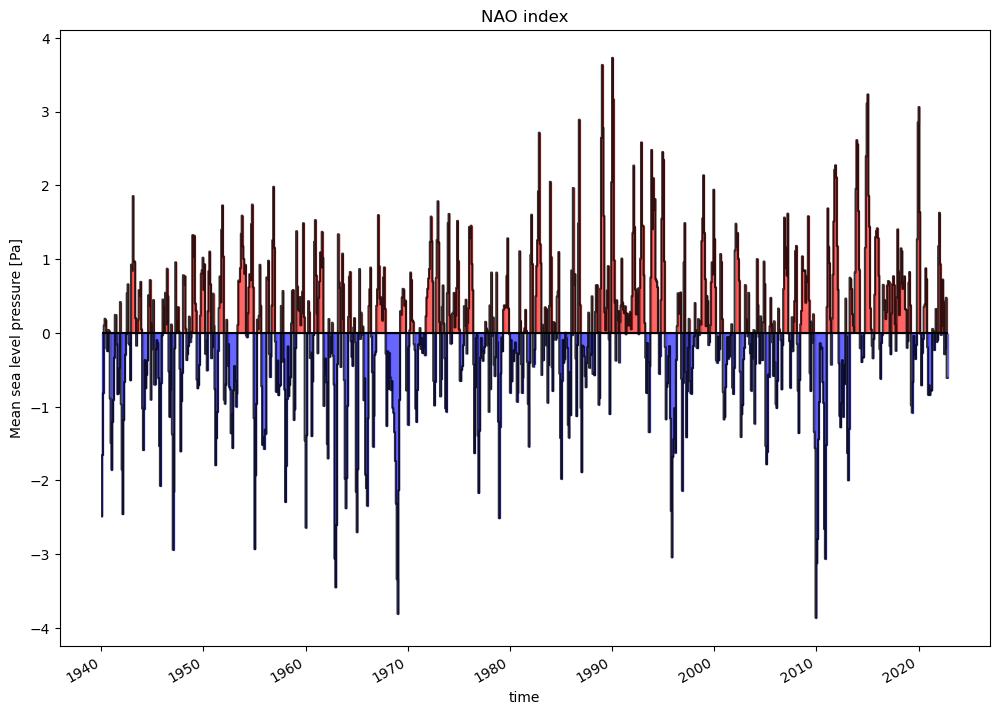

In [5]:
nao = station_based_index(field=infile,namelist=namelist,telecname=telecname,months_window=3,loglevel='INFO')
index_plot(nao,title='NAO index',save=False,xlabel='time')

## Regression plot

To visualize the teleconnection on a 2D plot, functions in the `plots.py` are introduced.
There is an option `plot=True` that creates a plot of the regression. Additionally an xarray containing the result of the regression is returned, if needed for further analysis or storage.
A custom projection can be specified, here the `LambertConformal` projection is used.

(<xarray.DataArray (lat: 180, lon: 360)>
 dask.array<truediv, shape=(180, 360), dtype=float64, chunksize=(180, 360), chunktype=numpy.ndarray>
 Coordinates:
   * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
   * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
 Attributes:
     standard_name:  air_pressure_at_mean_sea_level
     long_name:      Mean sea level pressure
     units:          Pa
     code:           151
     table:          128
     history:        2023-06-13 14:50:00 variable renamed by AQUA fixer;\n2023...
     paramId:        151
     cfVarName:      msl
     shortName:      msl
     regridded:      1,
 <Figure size 800x400 with 2 Axes>,
 <GeoAxes: title={'center': 'NAO index'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>)

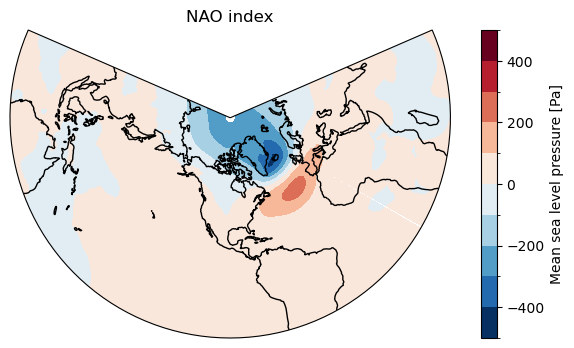

In [6]:
reg_plot(nao,infile,projection_type='LambertConformal',title='NAO index',contour=True,levels=10)

## Comparison with NCAR data

With the NAO index computed, we can compare with observational data from NCAR, to check if the index is computed correctly.

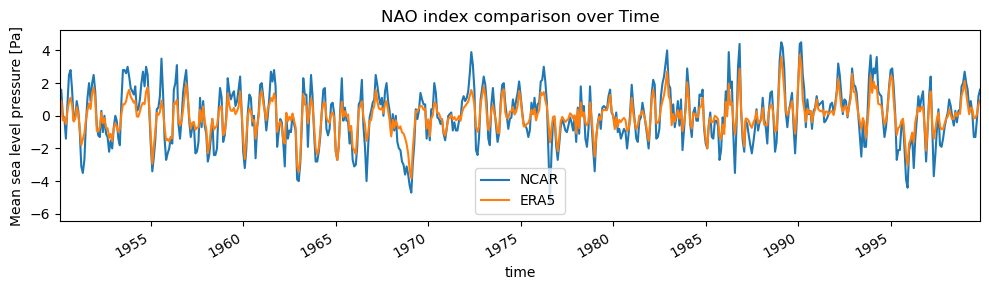

In [8]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

ncar_path = '../data/nao_station_seasonal.txt'
nao_ncar = np.genfromtxt(ncar_path,skip_header=3,skip_footer=4)

year = nao_ncar[:,0]
month_data = nao_ncar[:, 1:]
time = xr.cftime_range(start=str(int(year[0])),periods=12*len(year),freq='MS',calendar='standard')
month_data = month_data.reshape(-1)
nao_ncar = xr.DataArray(month_data, coords=[time], dims=['time'], name='monthly_data')

time_vals = np.array(time.values)

# Convert to datetime objects
datetimes = [np.datetime64(t).astype(datetime.datetime) for t in time_vals]

# Plot with matplotlib
fig = plt.figure(figsize=(10,3))
plt.plot(datetimes, nao_ncar.values,label='NCAR')

plt.xlim(datetime.datetime(1950, 1, 31, 0, 0),datetime.datetime(1999, 10, 31, 0, 0))

nao.plot(label='ERA5')
plt.legend()
plt.title('NAO index comparison over Time')
fig.tight_layout()

plt.show()